# Data preparation

## Setup

In [1]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)

Windows-10-10.0.19045-SP0
Python 3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]


In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

## Load data

In [3]:
train_raw = pd.read_csv('../data/raw/train.csv')
test_raw = pd.read_csv('../data/raw/test.csv')

print(f'Raw train dataset has {train_raw.shape[0]} observations of {train_raw.shape[1]} variables.')
print(f'Raw test dataset has {test_raw.shape[0]} observations of {test_raw.shape[1]} variables.')

train_raw.head(5)

Raw train dataset has 8693 observations of 14 variables.
Raw test dataset has 4277 observations of 13 variables.


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Variables:

* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

## Quick exploration

In [4]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
TARGET = 'Transported'
FEATURES = [col for col in train_raw.columns if col not in [TARGET]]

numerical = train_raw[FEATURES].select_dtypes(include=np.number).columns
categorical = train_raw[FEATURES].select_dtypes(exclude=np.number).columns

print(f'Target: {TARGET}')
print(f'Features:\n\tnumerical: {numerical.to_list()}\n\tcategorical:{categorical.to_list()}')
print(f'Shapes:\n\ttrain: {train_raw.shape}\n\ttest: {test_raw.shape}')

Target: Transported
Features:
	numerical: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
	categorical:['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']
Shapes:
	train: (8693, 14)
	test: (4277, 13)


In [6]:
train_raw.duplicated().sum(), test_raw.duplicated().sum()

(0, 0)

In [7]:
info_df = pd.DataFrame({
    'missing': train_raw.isna().sum(),
    'nunique': train_raw.nunique(),
    'dtypes': train_raw.dtypes
})
info_df

,missing,nunique,dtypes
PassengerId,0,8693,object
HomePlanet,201,3,object
CryoSleep,217,2,object
Cabin,199,6560,object
Destination,182,3,object
Age,179,80,float64
VIP,203,2,object
RoomService,181,1273,float64
FoodCourt,183,1507,float64
ShoppingMall,208,1115,float64


## Quick eda

In [8]:
os.makedirs('figures/eda_1', exist_ok=True)
plt.rcParams["figure.figsize"] = (1.618* 5, 5)
sns.set_style('darkgrid')
sns.set_palette('muted')

### Response distribution

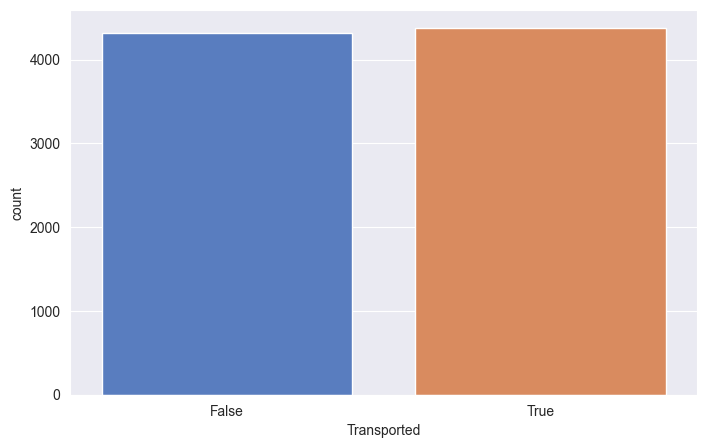

In [9]:
sns.countplot(x=TARGET, data=train_raw)
plt.savefig('figures/eda_1/countplot_response_marginal.png')

### Continuous features

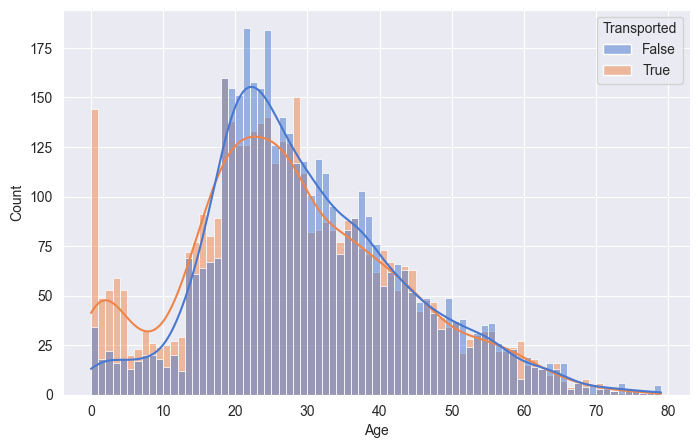

In [10]:
sns.histplot(data=train_raw, x='Age', hue='Transported', binwidth=1, kde=True)
plt.savefig('figures/eda_1/histplot_age_marginal.png')

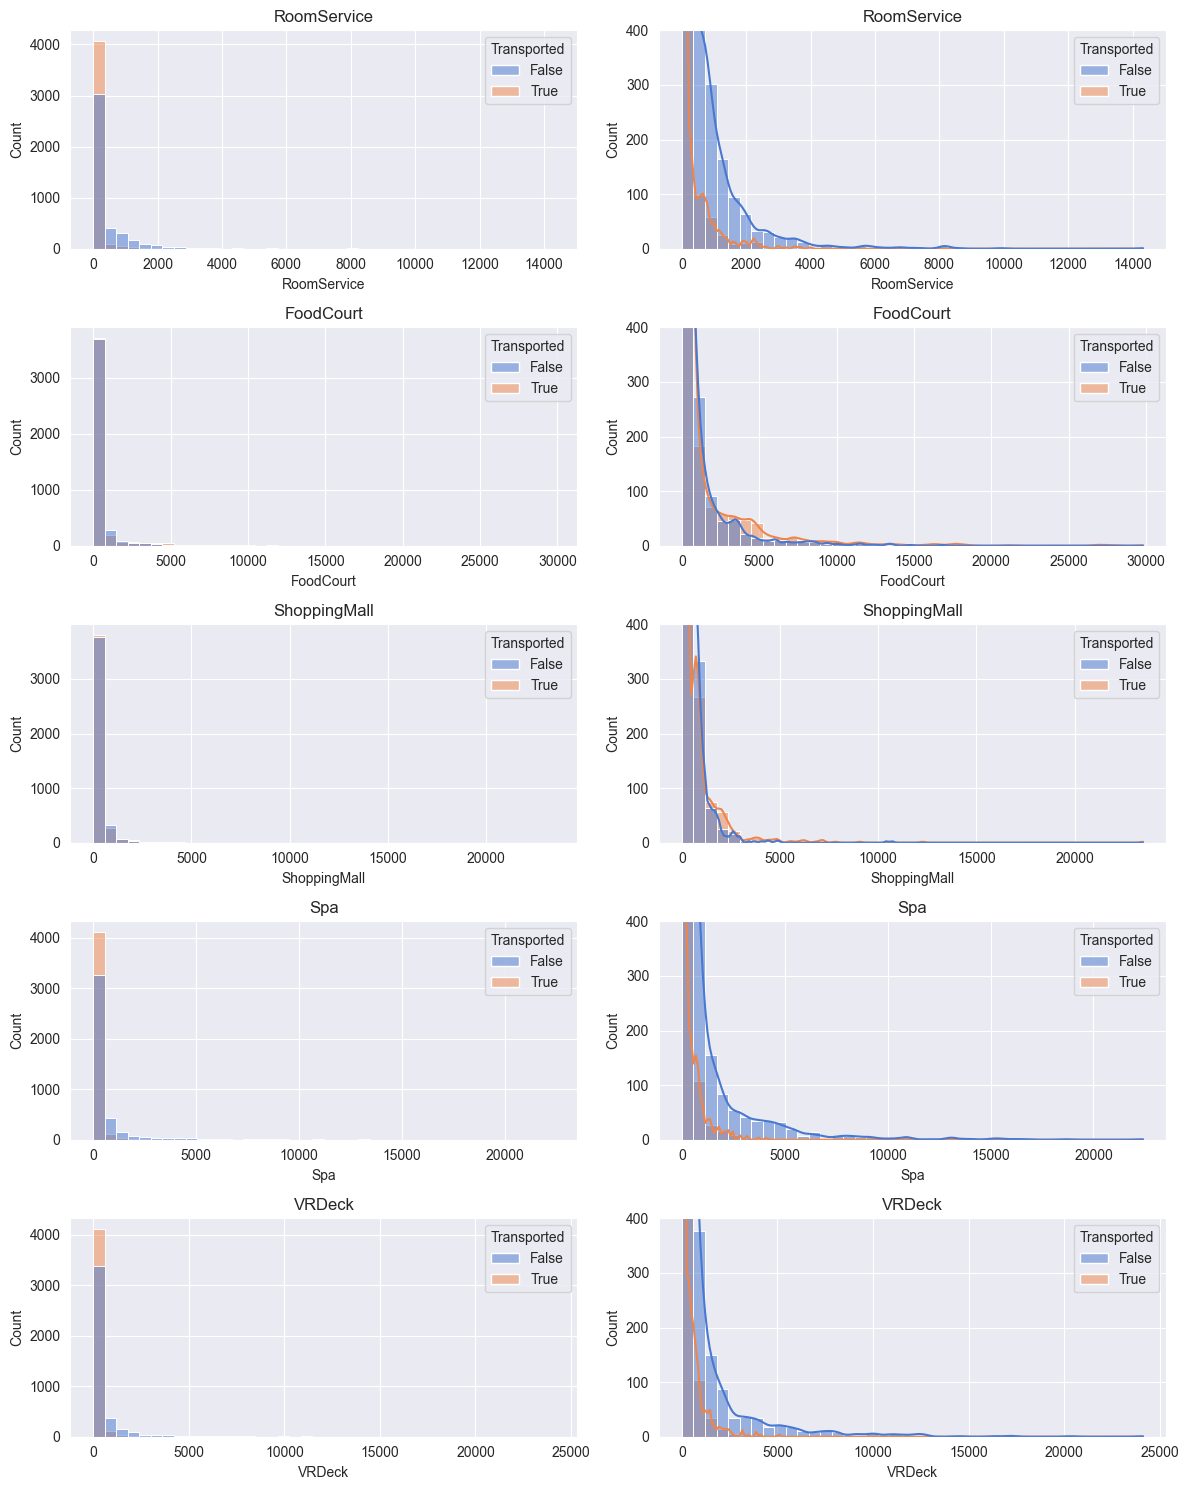

In [11]:
# expenditure features
exp_feats = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig = plt.figure(figsize=(12, 15))
for i, var_name in enumerate(exp_feats):
    
    # left plot
    ax = fig.add_subplot(5, 2, 2*i+1)
    sns.histplot(data=train_raw, x=var_name, bins=40, kde=False, hue=TARGET, axes=ax)
    ax.set_title(var_name)
    
    # right plot (truncated)
    ax = fig.add_subplot(5, 2, 2*i+2)
    sns.histplot(data=train_raw, x=var_name, bins=40, kde=True, hue=TARGET, axes=ax)
    plt.ylim([0, 400])
    ax.set_title(var_name)

fig.tight_layout()
plt.savefig('figures/eda_1/histplot_exp_feats.png')

### Categorical features

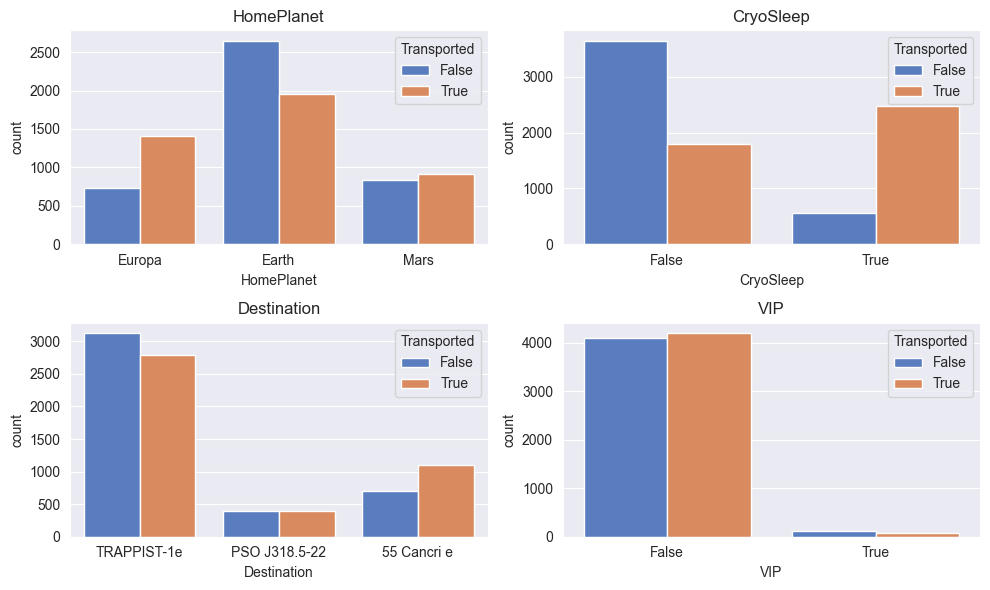

In [12]:
cat_feats = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# plot categorical features
fig = plt.figure(figsize=(10,6))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(2, 2,i+1)
    sns.countplot(data=train_raw, x=var_name, axes=ax, hue=TARGET)
    ax.set_title(var_name)

fig.tight_layout()
plt.savefig('figures/eda_1/countplot_categorical_marginal.png')

In [13]:
# other qualitative features
qual_feats = ['PassengerId', 'Cabin' ,'Name']

# preview qualitative features
train_raw[qual_feats].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


## Feature engineering

In [14]:
exp_feats = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

def preprocess(d):
    
    # feature engineering

    # create feature group
    d['Group'] = d['PassengerId'].str.split('_', expand=True)[0].astype(float)

    # create feature surname
    d['Name'].fillna('Unknown Unknown', inplace=True)
    d['Surname'] = d['Name'].str.split().str[-1]

    # expenditure features
    d['Expenditure'] = d[exp_feats].sum(axis=1)
    d['NoSpending'] = (d['Expenditure']==0).astype(object)

    # split cabin information
    # input nas before splitting
    d['Cabin'].fillna('Z/9999/Z', inplace=True)
    
    d[['CabinDeck', 'CabinNum', 'CabinSide']] = d['Cabin'].str.split('/', expand=True)
    d['CabinNum'] = d['CabinNum'].astype(float)

    # put nas back in
    d.loc[d['CabinDeck']=='Z', 'CabinDeck'] = np.nan
    d.loc[d['CabinNum']==9999, 'CabinNum'] = np.nan
    d.loc[d['CabinSide']=='Z', 'CabinSide'] = np.nan

    # cut Age into bins
    d['AgeGroup']=pd.cut(d['Age'], bins=[-1, 12, 17, 25, 30, 40, 50, 99]).astype(object)

    # drop useless features
    d.drop(columns=['Cabin', 'Name'], inplace=True)

    return d

# apply feature engineering
train_fe1 = preprocess(train_raw)
test_fe1 = preprocess(test_raw)

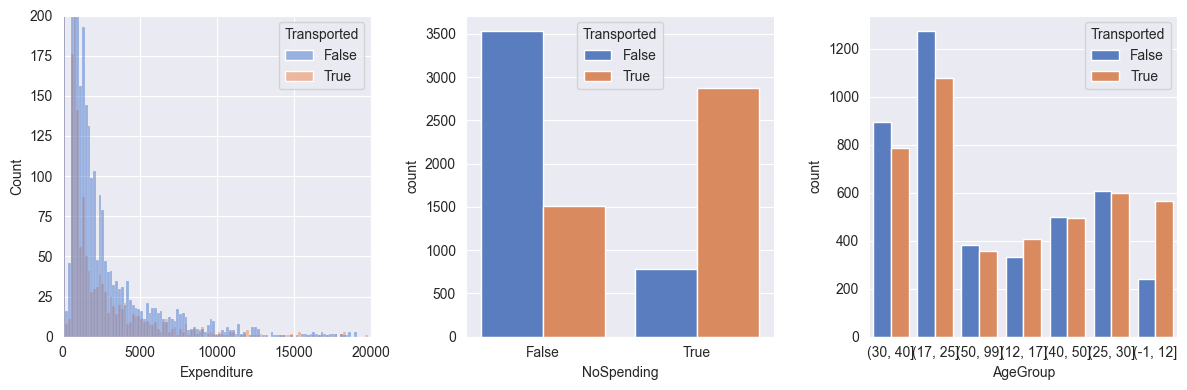

In [15]:
# features Expenditure and NoSpending

fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1, 3, 1)
sns.histplot(ax=ax, data=train_fe1, x='Expenditure', hue=TARGET, bins=200)
plt.ylim([0,200])
plt.xlim([0,20000])

ax = fig.add_subplot(1, 3, 2)
sns.countplot(ax=ax, data=train_fe1, x='NoSpending', hue=TARGET)

ax = fig.add_subplot(1, 3, 3)
sns.countplot(ax=ax, data=train_fe1, x='AgeGroup', hue=TARGET)

fig.tight_layout()
plt.savefig('figures/eda_1/displot_added_features.png')

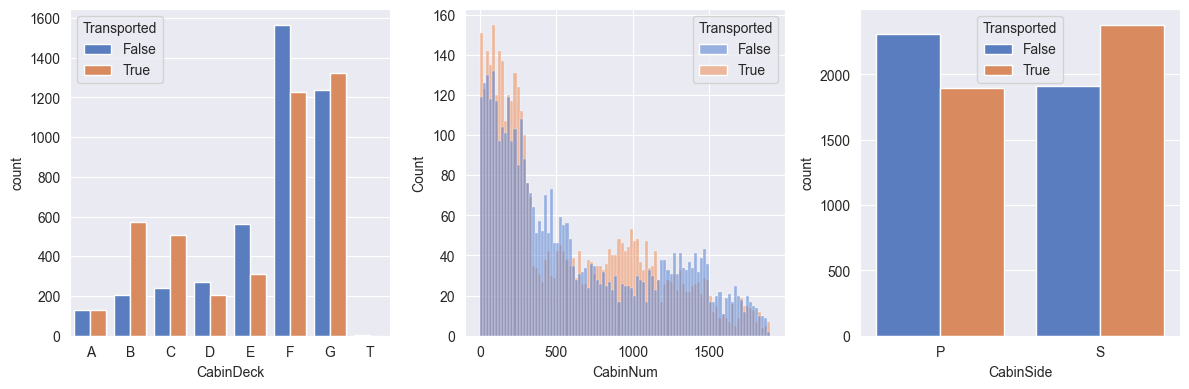

In [16]:
fig = plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.countplot(data=train_fe1, x='CabinDeck', hue='Transported', order=['A','B','C','D','E','F','G','T'])

plt.subplot(1, 3, 2)
sns.histplot(data=train_fe1, x='CabinNum', hue='Transported',binwidth=20)

plt.subplot(1, 3, 3)
sns.countplot(data=train_fe1, x='CabinSide', hue='Transported')

fig.tight_layout()
plt.savefig('figures/eda_1/displot_added_features_2.png')

In [17]:
# additional features GroupCount and FamilySize
tomerge1 = pd.concat([train_fe1, test_fe1])[['Group', 'PassengerId']].groupby('Group').count().rename(columns={'PassengerId': 'GroupSize'}).reset_index()
tomerge2 = pd.concat([train_fe1, test_fe1])[['Surname', 'PassengerId']].groupby('Surname').count().rename(columns={'PassengerId': 'FamilySize'}).reset_index()

train_fe2 = train_fe1.merge(tomerge1, on='Group').merge(tomerge2, on='Surname')
test_fe2 = test_fe1.merge(tomerge1, on='Group').merge(tomerge2, on='Surname')

train_fe2.sort_values(by='PassengerId', inplace=True)
test_fe2.sort_values(by='PassengerId', inplace=True)

In [18]:
def preprocess2(d):

    # add Solo
    d['Solo'] = (d['GroupSize']==1).astype(object)

    d.loc[d['Surname']=='Unknown','Surname'] = np.nan
    d.loc[d['FamilySize']>100,'FamilySize'] = np.nan

    # cut Cabin number into bins
    d['CabinGroup']=pd.cut(d['CabinNum'], bins=[-10, 300, 600, 900, 1200, 1500, 1800, 2500]).astype(object)

    # set CabinDeck T to none since it has few values, it will go in the same category as missing values
    d.loc[d['CabinDeck']=='T', 'CabinDeck'] = np.nan
    
    return d

# apply feature engineering 2
train = preprocess2(train_fe2)
test = preprocess2(test_fe2)

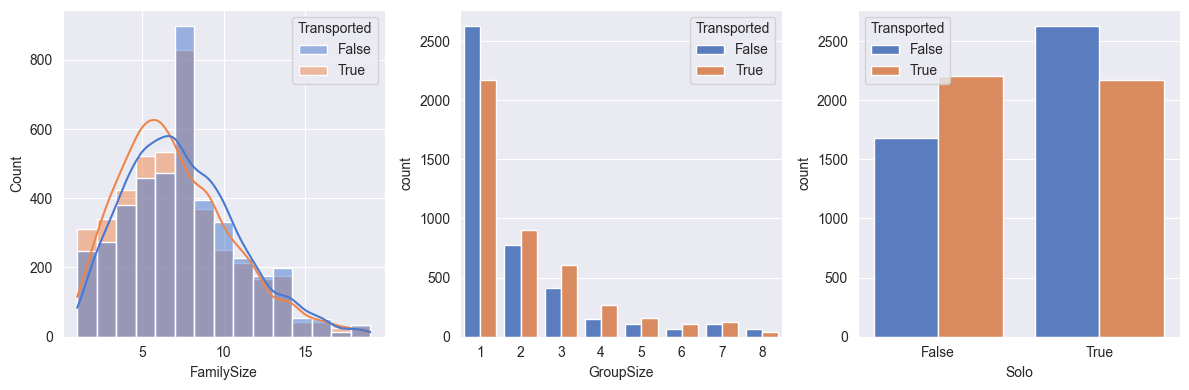

In [19]:
# Plot distribution of new features
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1, 3, 1)
sns.histplot(ax=ax, data=train, x='FamilySize', kde=True, bins=15, hue=TARGET)

ax = fig.add_subplot(1, 3, 2)
sns.countplot(ax=ax, data=train, x='GroupSize', hue=TARGET)

ax = fig.add_subplot(1, 3, 3)
sns.countplot(ax=ax, data=train, x='Solo', hue=TARGET)

fig.tight_layout()
plt.savefig('figures/eda_1/displot_added_features_3.png')

In [20]:
# drop unwanted features
ids = [train['PassengerId'], test['PassengerId']]
todrop = ['PassengerId', 'Surname', 'Group', 'CabinGroup', 'AgeGroup']
train.drop(columns=todrop, inplace=True)
test.drop(columns=todrop, inplace=True)

In [21]:
TARGET = 'Transported'
FEATURES = [col for col in train.columns if col not in [TARGET]]

numerical = train[FEATURES].select_dtypes(include=np.number).columns
categorical = train[FEATURES].select_dtypes(exclude=np.number).columns

print(f'Target: {TARGET}')
print(f'Features:\n\tnumerical: {numerical.to_list()}\n\tcategorical:{categorical.to_list()}')
print(f'Shapes:\n\ttrain: {train.shape}\n\ttest: {test.shape}')

Target: Transported
Features:
	numerical: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure', 'CabinNum', 'GroupSize', 'FamilySize']
	categorical:['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'NoSpending', 'CabinDeck', 'CabinSide', 'Solo']
Shapes:
	train: (8693, 19)
	test: (4277, 18)


## Missing values

In [22]:
info_df = pd.DataFrame({
    'missing': train.isna().sum(),
    'nunique': train.nunique(),
    'dtypes': train.dtypes
})
info_df

,missing,nunique,dtypes
HomePlanet,201,3,object
CryoSleep,217,2,object
Destination,182,3,object
Age,179,80,float64
VIP,203,2,object
RoomService,181,1273,float64
FoodCourt,183,1507,float64
ShoppingMall,208,1115,float64
Spa,183,1327,float64
VRDeck,188,1306,float64


In [23]:
# define impute strategies
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')

# combine preprocessing
ct = ColumnTransformer(
    transformers=[
        ('num', num_imputer, numerical.to_list()),
        ('cat', cat_imputer, categorical.to_list())],
        remainder='passthrough')

# apply preprocessing
x = train[FEATURES]
y = train[TARGET]

FEATURES = numerical.to_list() + categorical.to_list()
typedict = {k:v for (k,v) in zip(FEATURES, ['float64' if f in numerical.to_list() else 'object' for f in FEATURES])}

ct = ct.fit(x)
x = pd.DataFrame(ct.transform(x), columns=FEATURES).astype(typedict)
test = pd.DataFrame(ct.transform(test), columns=FEATURES).astype(typedict)

train = x.copy()
train[TARGET] = y.values

In [24]:
# final check
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

## Preprocessing

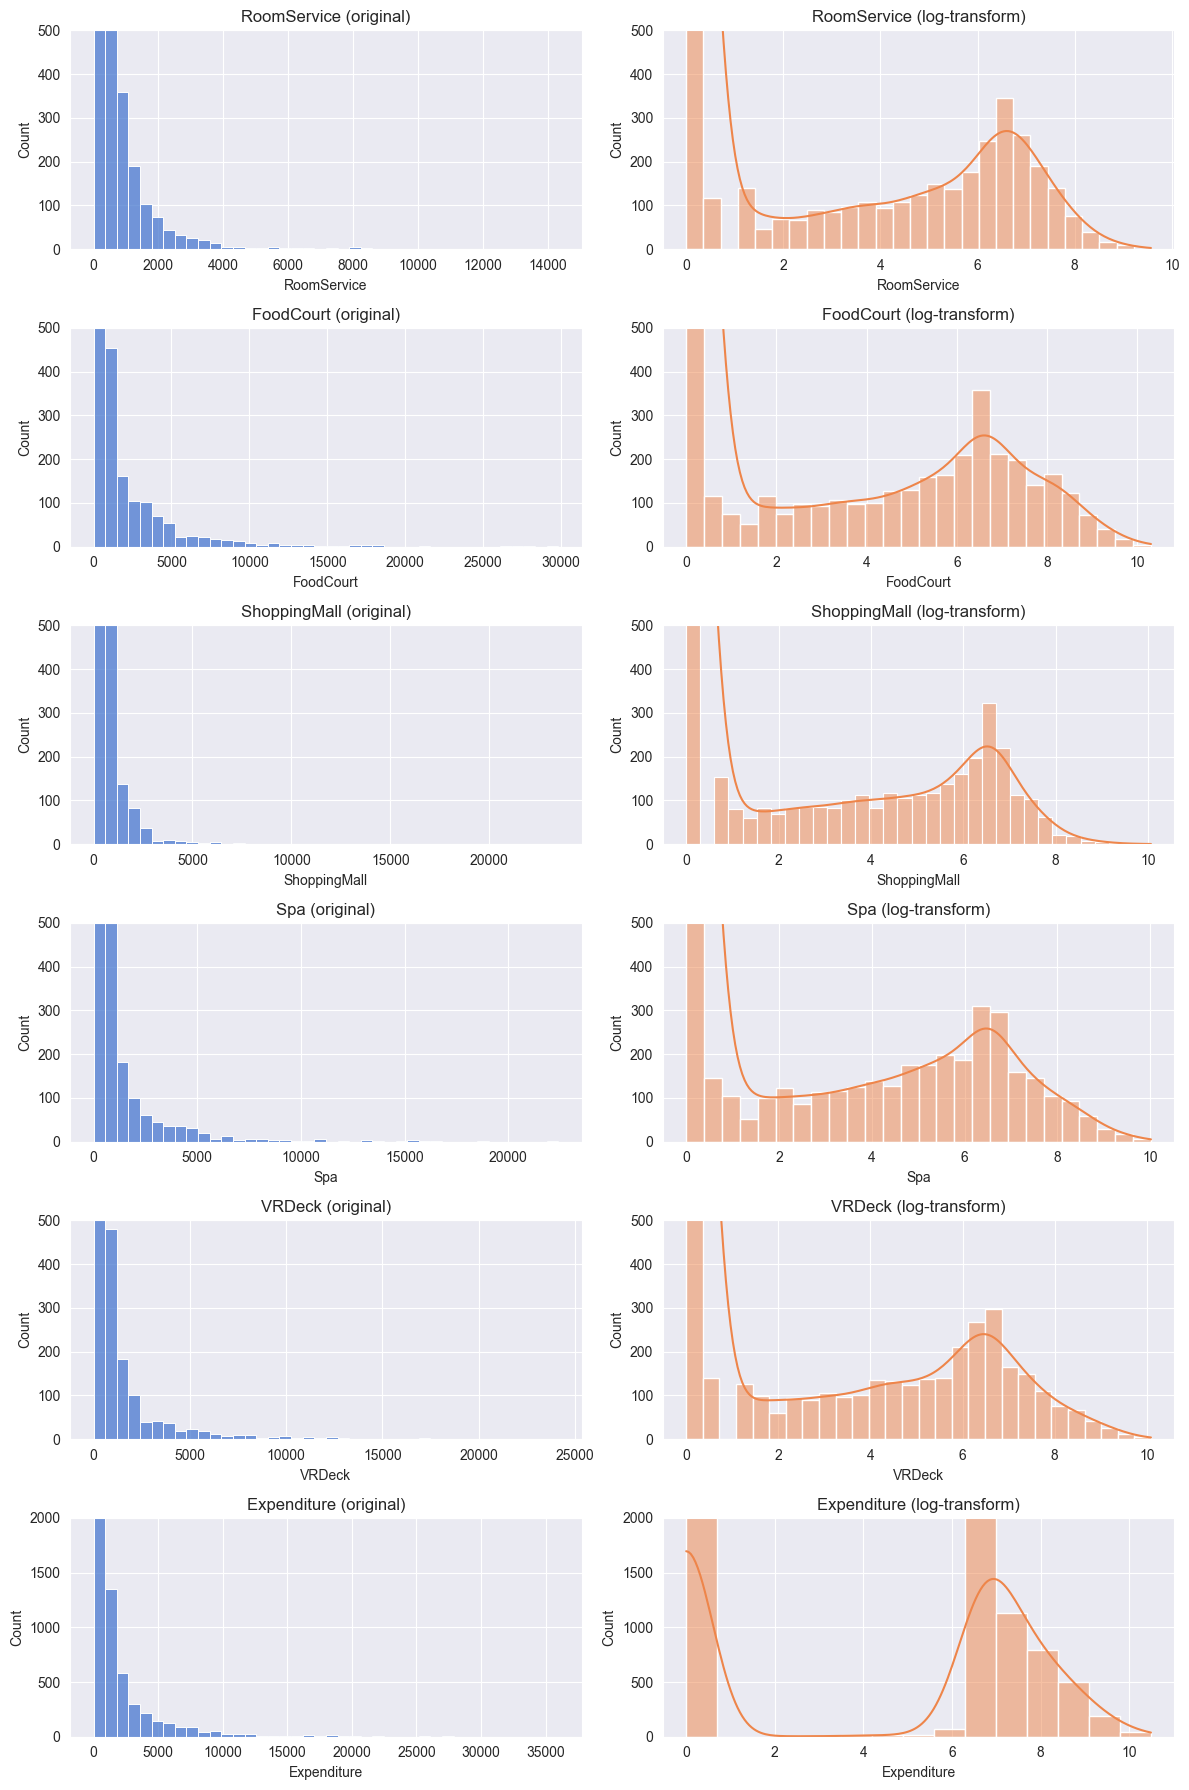

In [25]:
# plot log transform results
exp_feats = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure']

fig = plt.figure(figsize=(12, 18))
for i, col in enumerate(exp_feats):
    plt.subplot(6,2,2*i+1)
    sns.histplot(train[col], bins=40, kde=False)
    plt.title(f'{col} (original)')
    if i==5:
        plt.ylim([0, 2000])
    else:
        plt.ylim([0, 500])
    
    plt.subplot(6,2,2*i+2)
    sns.histplot(np.log(1+train[col]), color='C1', kde=True)
    plt.title(f'{col} (log-transform)')
    if i==5:
        plt.ylim([0, 2000])
    else:
        plt.ylim([0, 500])
    
fig.tight_layout()
plt.savefig('figures/eda_1/histplot_exp_feats_log.png')

In [26]:
# apply log transform
for col in exp_feats:
    train[col] = np.log(1+train[col])
    test[col] = np.log(1+test[col])

## Recap and save

In [27]:
TARGET = 'Transported'
FEATURES = [col for col in train.columns if col not in [TARGET]]

numerical = train[FEATURES].select_dtypes(include=np.number).columns
categorical = train[FEATURES].select_dtypes(exclude=np.number).columns

print(f'Target: {TARGET}')
print(f'Features:\n\tnumerical: {numerical.to_list()}\n\tcategorical:{categorical.to_list()}')
print(f'Shapes:\n\ttrain: {train.shape}\n\ttest: {test.shape}')

train.head()

Target: Transported
Features:
	numerical: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure', 'CabinNum', 'GroupSize', 'FamilySize']
	categorical:['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'NoSpending', 'CabinDeck', 'CabinSide', 'Solo']
Shapes:
	train: (8693, 19)
	test: (4277, 18)


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Expenditure,CabinNum,GroupSize,FamilySize,HomePlanet,CryoSleep,Destination,VIP,NoSpending,CabinDeck,CabinSide,Solo,Transported
0,39.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,3.0,Europa,False,TRAPPIST-1e,False,True,B,P,True,False
1,24.0,4.700480,2.302585,3.258097,6.309918,3.806662,6.602588,0.0,1.0,4.0,Earth,False,TRAPPIST-1e,False,False,F,S,True,True
2,58.0,3.784190,8.182280,0.000000,8.812248,3.912023,9.248021,0.0,2.0,7.0,Europa,False,TRAPPIST-1e,True,False,A,S,False,False
3,33.0,0.000000,7.157735,5.918894,8.110728,5.267858,8.551981,0.0,2.0,7.0,Europa,False,TRAPPIST-1e,False,False,A,S,False,False
4,16.0,5.717028,4.262680,5.023881,6.338594,1.098612,6.995766,1.0,1.0,9.0,Earth,False,TRAPPIST-1e,False,False,F,S,True,True


In [28]:
# save preprocessed data
os.makedirs('../data/final', exist_ok=True)
train.to_csv('../data/final/train.csv', index=False)
test.to_csv('../data/final/test.csv', index=False)